# Similarity improvement due to NvP recommendation

Given a random pair of movies, how much similar are the recommendarion produced by NvP from the original simialrity of the target movies?

In [1]:
import gensim
from gensim.models.doc2vec import Doc2Vec
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();
from tqdm import notebook, tqdm
import math

In [2]:
#load model
directory = '/Users/dbikiel/Documents/Insight-Local/notebooks/'
model = Doc2Vec.load(directory + 'model_doc2vec_20120123')
titles = pd.read_csv('/Users/dbikiel/PycharmProjects/Insight/data/ml-25m/movies.csv')
ratings = pd.read_csv('/Users/dbikiel/PycharmProjects/Insight/data/ml-25m/ratings.csv')
metadata = pd.read_csv('/Users/dbikiel/PycharmProjects/Insight/data/TMDB-metadata-62K.csv')

metadata['movieId'] = titles.movieId
movieId = list(titles.movieId.values)
movieid_to_doctags = {int(movie): i for i, movie in enumerate(movieId)}

Let's create a simialr function as the one used in the app to recommend movies, but it returns the average similarity of the recommendation from each one of the users selected movies

In [15]:
def find_middle_with_filter(model, data_df, movieid_to_doctags, movies, topn, remove_movies):
    """
    Function to search a movie in between two other movies. Uses the a doc2vec trained model an a database
    of movies to find the topn closest movies.
    :param model: a doc2vec model
    :param data_df: a pandas dataframe containing id, title, rating, votes, overview
    :param movieid_to_doctags: dict to transform movie id to doctag id
    :param movies: list of id of 2 movies
    :param topn: number of similarity searches for each movie integer
    :param remove_movies: id of movies to remove from the final result
    :return:
    """

    # get the ids from the list
    movie1 = int(movies[0])
    movie2 = int(movies[1])

    to_remove = [int(remove_movies[0]), int(remove_movies[1])]

    # titles and movieIds from the dataframe
    title = list(data_df['title'])
    movieId = list(data_df['movieId'])

    movieid_to_title = {movie: tit for movie, tit in zip(movieId, title)}

    # set of vectors to search the similarity
    vectors = set([movieid_to_doctags[movie] for movie in movieId])

    # dict to convert doctags
    doctag_to_movieId = {j: i for i, j in zip(movieid_to_doctags.keys(), movieid_to_doctags.values())}
    #doctag_to_title = {j: i for i, j in zip(vectors, title)}

    # Get the vectors of the target movies
    vec1 = model.docvecs[movieid_to_doctags[movie1]]
    vec2 = model.docvecs[movieid_to_doctags[movie2]]

    # Search topn similar movies for each movie
    vec1_sim = model.docvecs.most_similar([vec1], topn=topn)
    vec2_sim = model.docvecs.most_similar([vec2], topn=topn)

    # Unpack vectors
    vec1_sim_doctags, vec1_sim_sim = zip(*vec1_sim)
    vec2_sim_doctags, vec2_sim_sim = zip(*vec2_sim)

    # Create the intersection of the most similar movies
    intersection = set(vec1_sim_doctags).intersection(set(vec2_sim_doctags))
    intersection = intersection.intersection(vectors)

    # if the target movies are in the intersection, is removed
    if movieid_to_doctags[movie1] in intersection:
        intersection.remove(movieid_to_doctags[movie1])
    if movieid_to_doctags[movie2] in intersection:
        intersection.remove(movieid_to_doctags[movie2])

    # Remove the movies in the remove list if they are in the intersection
    for movie in to_remove:
        if movieid_to_doctags[movie] in intersection:
            intersection.remove(movieid_to_doctags[movie])

    # Create list for different parameters to produce the final result
    # id
    movie_id = []
    tit = []

    # similarity to movie 1 or 2
    user1_sim = []
    user2_sim = []

    # mean and std similarity
    mean_sim = []
    std_sim = []

    # absolute difference of the difference between the similarity
    ineq_sim = []

    # Product of the similarity
    prod_sim = []

    # mean similarity - absolute difference
    mean_ineq_sim = []

    # std divided by mean similarity
    std_over_mean_sim = []

    # For each movie found calculates all the parameters
    
    target_sim = model.docvecs.similarity(movieid_to_doctags[movie1], movieid_to_doctags[movie2])
    
    for i in intersection:
        tit.append(movieid_to_title[doctag_to_movieId[i]])
        #id
        movie_id.append(doctag_to_movieId[i])

        # movie similarity versus movie1 and movie2
        sim1 = vec1_sim_sim[vec1_sim_doctags.index(i)]
        sim2 = vec2_sim_sim[vec2_sim_doctags.index(i)]

        # similarities
        user1_sim.append(np.round(sim1, 3))
        user2_sim.append(np.round(sim2, 3))

        # mean and std
        mean_sim.append(np.round(0.5 * (sim1 + sim2), 3))
        std_sim.append(np.round(np.std(np.array([sim1, sim2])), 3))

        # absolute difference, product, mean - abs, std / mean
        ineq_sim.append(np.round(abs(sim1 - sim2), 3))
        prod_sim.append(np.round(sim1 * sim2, 3))
        mean_ineq_sim.append(np.round(0.5 * (sim1 + sim2) - 0.5 * abs(sim1 - sim2), 3))
        std_over_mean_sim.append(np.round(np.std(np.array([sim1, sim2])) / (0.5 * (sim1 + sim2)), 3))

    # creates a dataframe with all the results
    results = {'title': tit, 'id': movie_id, 'user1_sim': user1_sim,
               'user2_sim': user2_sim, 'mean_sim': mean_sim, 'std_sim': std_sim, 'ineq_sim': ineq_sim,
               'prod_sim': prod_sim, 'mean_ineq_sim': mean_ineq_sim, 'std_over_mean_sim': std_over_mean_sim}

    res = pd.DataFrame(results)

    # produces the final result, sorting by mean - abs. Only first 6 results
    #final = res.sort_values(by=['mean_ineq_sim'], ascending=False).head(6)
    final = res.sort_values(by=['mean_ineq_sim'], ascending=False)
    #print(target_sim)
    #print(final[['user1_sim','user2_sim']])
    # returns a list of movie ids
    #row = [movie1,movie2,target_sim,np.mean(final.user1_sim), np.mean(final.user2_sim)]
    #return list(final['id'])
    #return row
    return final


I will filter movies with ratings below 5 and votes below 500

In [28]:
c1 = metadata.vote_average > 5
c2 = metadata.vote_count > 500
filtered_movies = titles[titles.movieId.isin(metadata[c1 & c2].movieId)]

And let's see what the system recommends for "Seven Samurai" and "Bolt"

In [33]:
movies = [2019, 63859]
res = find_middle_with_filter(model, filtered_movies, movieid_to_doctags, movies, 2000, movies)
res

,title,id,user1_sim,user2_sim,mean_sim,std_sim,ineq_sim,prod_sim,mean_ineq_sim,std_over_mean_sim
8,Rango (2011),84944,0.337,0.340,0.339,0.002,0.004,0.115,0.337,0.006
5,Mulan (1998),1907,0.513,0.333,0.423,0.090,0.180,0.171,0.333,0.213
1,The Jungle Book (2016),137857,0.332,0.330,0.331,0.001,0.002,0.110,0.330,0.003
4,Wolf Children (Okami kodomo no ame to yuki) (2...,101962,0.411,0.321,0.366,0.045,0.091,0.132,0.321,0.124
3,Cargo (2017),188541,0.364,0.320,0.342,0.022,0.045,0.117,0.320,0.065
2,"Garden of Words, The (Koto no ha no niwa) (2013)",109633,0.318,0.345,0.331,0.013,0.027,0.110,0.318,0.040
0,Volver (2006),44694,0.335,0.317,0.326,0.009,0.018,0.106,0.317,0.027
6,The Red Turtle (2016),160848,0.315,0.314,0.314,0.000,0.001,0.099,0.314,0.001
7,"Girl Who Leapt Through Time, The (Toki o kaker...",57504,0.336,0.312,0.324,0.012,0.024,0.105,0.312,0.037


Let's create 10K random pair of movies, obtain the recommendation 

In [115]:
n = 10000
test = [(i,j) for i,j in zip(random.choices(movieId,k = n),random.choices(movieId,k = n))]

In [116]:
rows = []
for par in tqdm(test):
    row = find_middle_with_filter(model, titles, movieid_to_doctags, par, 2000, par)
    rows.append(row)

100%|██████████| 10000/10000 [12:33<00:00, 13.27it/s]


Let's see how the original similarity (sim) compares to the similarity obtained from the recommendations for user 1 (user_sim1) and user 2(user_sim2)

In [ ]:
data_simulated = pd.DataFrame(rows, columns= ['movie1','movie2','sim','user1_sim','user2_sim'])
data_simulated

(array([1.260e+03, 6.861e+03, 1.681e+03, 1.570e+02, 2.700e+01, 7.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([0.29383333, 0.35106667, 0.4083    , 0.46553333, 0.52276667,
        0.58      , 0.63723333, 0.69446667, 0.7517    , 0.80893333,
        0.86616667]),
 <a list of 10 Patch objects>)

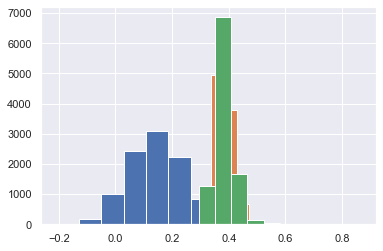

In [122]:
plt.hist(data_simulated.sim)
plt.hist(data_simulated.user1_sim)
plt.hist(data_simulated.user2_sim)

The distribution of the recommended movies are displaced to right, and are almost 3x more similar than the original ones

In [123]:
print(np.mean(data_simulated.sim),np.std(data_simulated.sim))
print(np.mean(data_simulated.user1_sim),np.std(data_simulated.user1_sim))
print(np.mean(data_simulated.user2_sim),np.std(data_simulated.user2_sim))
print(np.mean(data_simulated.user2_sim)/np.mean(data_simulated.sim))

0.1410587357162498 0.09641021164723354
0.38405765076507653 0.03259824112337066
0.384308167483415 0.033825815150535066
2.724454926751078


In [3]:
data_simulated.to_csv('10K random movie simulations and user similarity results.csv')
data_simulated = pd.read_csv('10K random movie simulations and user similarity results.csv')
data_simulated = data_simulated.drop('Unnamed: 0', axis = 1)

In [4]:
data_simulated.columns = ['movie1','movie2','movie1 vs movie2','recom. vs movie1','recom. vs movie2']

In [5]:
data_simulated_melt = data_simulated[['movie1 vs movie2','recom. vs movie1','recom. vs movie2']].melt()

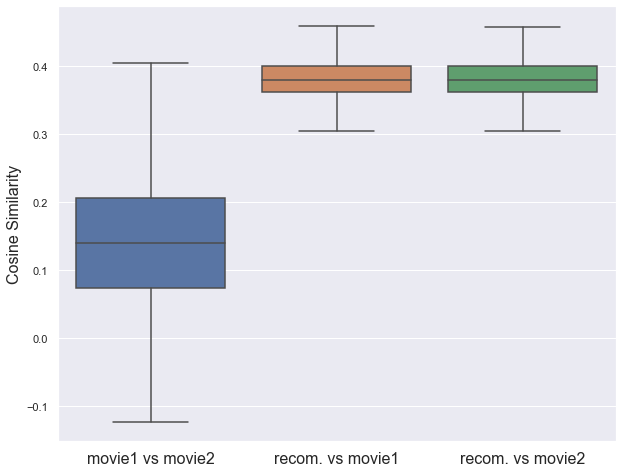

In [9]:
plt.figure(figsize=(10, 8))
sns.boxplot(data_simulated_melt.variable, data_simulated_melt.value, showfliers = False);
plt.ylabel('Cosine Similarity', FontSize = 16)
plt.xlabel('')
plt.xticks(FontSize = 16)
plt.savefig('Similarity between movies - boxplot no outliers.png')

There are a couple of cases that the original movies are better, but this occur when the orgianl was already very high in similarity:

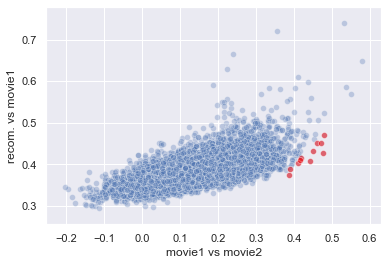

In [255]:
wrong = data_simulated[((data_simulated['recom. vs movie1'] - data_simulated['movie1 vs movie2']) < 0.0)]

sns.scatterplot(data_simulated['movie1 vs movie2'],data_simulated['recom. vs movie1'], alpha = 0.3)
sns.scatterplot(wrong['movie1 vs movie2'],wrong['recom. vs movie1'], color = 'red', alpha = 0.5)